In [71]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Connect to SQLite DB
conn = sqlite3.connect("data/bankdb.db")
cursor = conn.cursor() # Cursor object

In [38]:
# Check if the data loaded correctly with pandas
df = pd.read_sql("SELECT * FROM bank LIMIT 5;", conn)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [17]:
# Find unique jobs using cursor
cursor.execute("SELECT DISTINCT job FROM bank")

rows = cursor.fetchall()
for row in rows:
    print(row)

('unemployed',)
('services',)
('management',)
('blue-collar',)
('self-employed',)
('technician',)
('entrepreneur',)
('admin.',)
('student',)
('housemaid',)
('retired',)
('unknown',)


('admin.', 956)
('blue-collar', 1892)
('entrepreneur', 336)
('housemaid', 224)
('management', 1938)
('retired', 460)
('self-employed', 366)
('services', 834)
('student', 168)
('technician', 1536)
('unemployed', 256)
('unknown', 76)


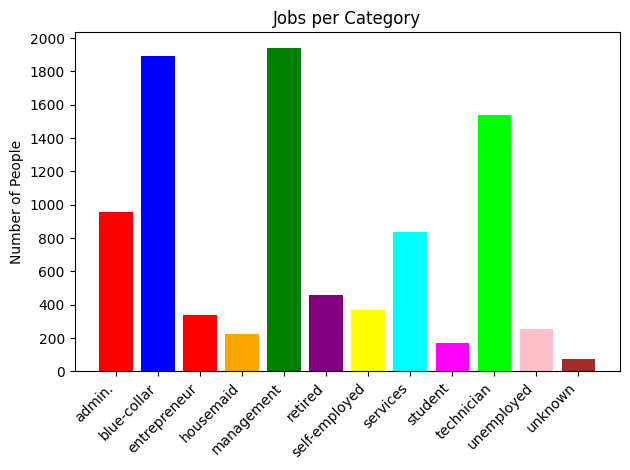

In [58]:
# Count how many people belong to each job category
cursor.execute("SELECT job, COUNT(job) as number_of_people FROM bank GROUP BY job")

rows = cursor.fetchall()
for row in rows:
    print(row)

# Make a bar chart visualization
fig, ax = plt.subplots()

jobs = [job for job, _ in rows]
counts = [count for _, count in rows]
bar_labels = ['red', 'blue', '_red', 'orange', 'green', 'purple', 'yellow', 'cyan',
              'magenta', 'lime', 'pink', 'brown']

bar_colors = ['red', 'blue', 'red', 'orange', 'green', 'purple',
              'yellow', 'cyan', 'magenta', 'lime', 'pink', 'brown']

ax.bar(jobs, counts, color=bar_colors)

ax.set_ylabel('Number of People')
ax.set_title('Jobs per Category')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=list(range(0, 2001, 200)))

plt.tight_layout()  # Adjust the layout to ensure labels don't get cut off
plt.show()

In [98]:
# Find average yearly balances for each job category whose balance is greater than 0
cursor.execute("""SELECT job, AVG(balance) as average_balance FROM
               bank WHERE balance > 0 GROUP BY job;""")
rows = cursor.fetchall()
for row in rows:
    print(row)

# Find largest average balances group
avg_balance = [balance for _, balance in rows]
idx = avg_balance.index(max(avg_balance))
idx
print("\nLargest balance category is :", rows[idx][0], "with avg. balance of", rows[idx][1])

('admin.', 1503.0680100755667)
('blue-collar', 1347.8520408163265)
('entrepreneur', 1881.986577181208)
('housemaid', 2548.141304347826)
('management', 2114.7880633373934)
('retired', 2685.85)
('self-employed', 1543.9583333333333)
('services', 1428.7981927710844)
('student', 1808.513888888889)
('technician', 1618.232198142415)
('unemployed', 1415.1666666666667)
('unknown', 1630.4285714285713)

Largest balance category is : retired with avg. balance of 2685.85


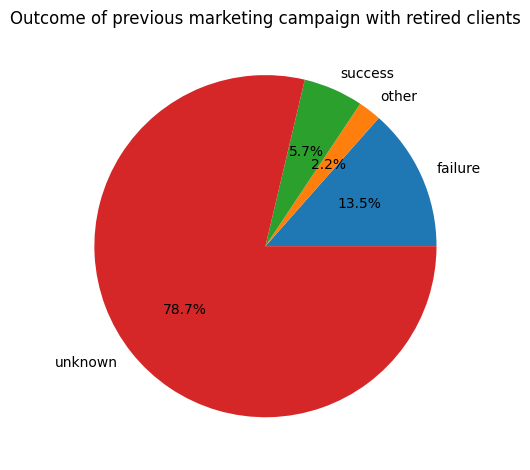

In [94]:
# What was the result of previous marketing campaign with the retired class people?
cursor.execute("""SELECT poutcome, COUNT(poutcome) as count
                FROM bank WHERE job="retired" GROUP BY poutcome;""")
rows = cursor.fetchall()

# Make a pie chart
labels = [label for label, _ in rows]
counts = [count for _, count in rows]
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.set_title("Outcome of previous marketing campaign with retired clients")
plt.tight_layout()
plt.show()
